#### *Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.*

### About

#### 50 000 USD per year is about 4 167 USD monthly.

SOURCE:<br>
http://archive.ics.uci.edu/ml/datasets/Adult <br>
https://www.kaggle.com/overload10/adult-census-dataset/tasks

### Importing Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import rcParams

### Importing the dataset

In [41]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("adult_data.txt", header=None, names = heading)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Analysis

### How many people in dataset have income >50K or <=50K

 <=50K    24720
 >50K      7841
Name: income, dtype: int64


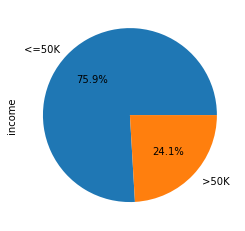

In [42]:
print(df['income'].value_counts())
df['income'].value_counts().plot.pie(autopct='%1.1f%%')

More people earn less or equal 5OK $.

### AGE

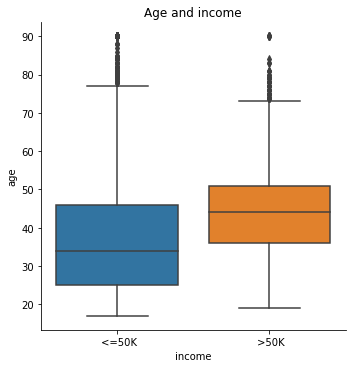

In [43]:
sns.catplot(x='income', y='age', kind="box", data=df)
plt.title('Age and income')
plt.show()

In [44]:
print('precise median age for >50K income : ',df[df['income']==' >50K']['age'].median(), 'yrs')

precise median age for >50K income :  44.0 yrs


In [45]:
print('precise median age for <=50K income : ',df[df['income']==' <=50K']['age'].median(), 'yrs')

precise median age for <=50K income :  34.0 yrs


MEDIAN value for people earning <=50K is around 35yrs, presicely.<br>
MEDIAN value for people earing >50K is around 45yrs.<br>
50% people who earn <=50K are between around 25 and 45. <br>
50% people who earn >50K are between around 38 and 50. <br>
IQR for >50K is visibly narrower than for <=50K.<br>

In [46]:
missing_values = df["age"] == " ?"
missing_values.value_counts()

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


False    32561
Name: age, dtype: int64

In [47]:
missing_values = df["age"] == 0
missing_values.value_counts()

False    32561
Name: age, dtype: int64

There is no missing values

### WORKCLASS

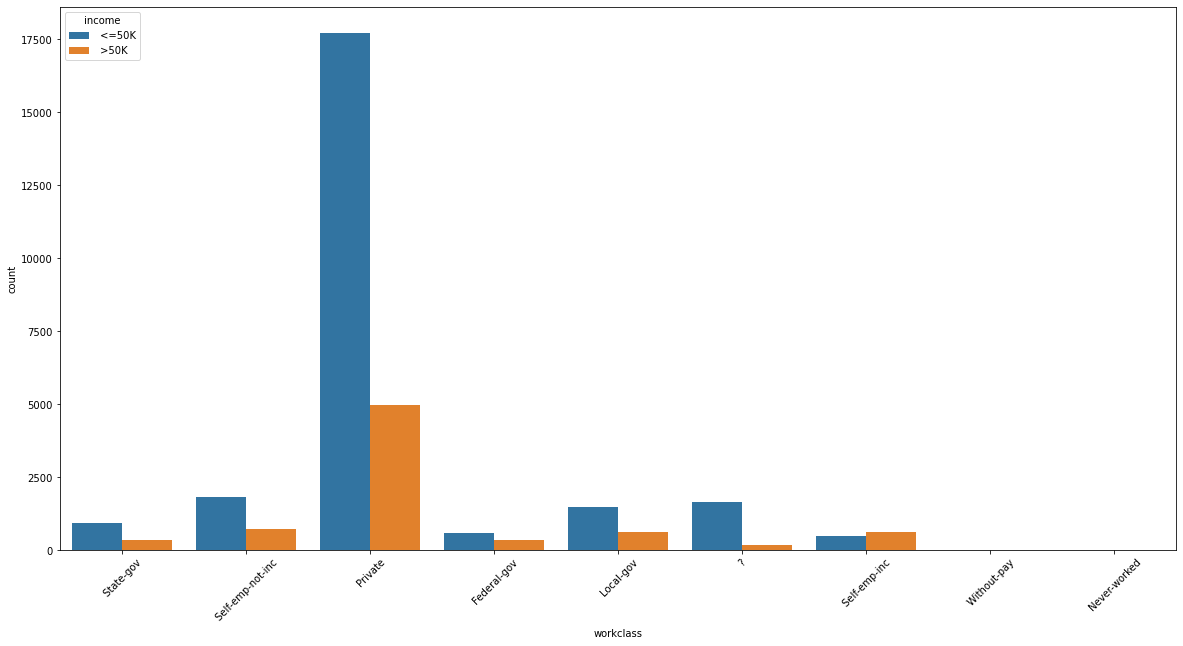

In [48]:
plt.subplots(figsize=(20, 10))
plt.xticks(rotation = 45)
sns.countplot(x = 'workclass', hue = 'income', data = df)
plt.show()

There is missing data " ?''. How many missing data?

In [49]:
print(df['workclass'].value_counts())

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64


There is plenty of missing values.

I create other cathegory for missing values.

### FNLWGT - Final weight

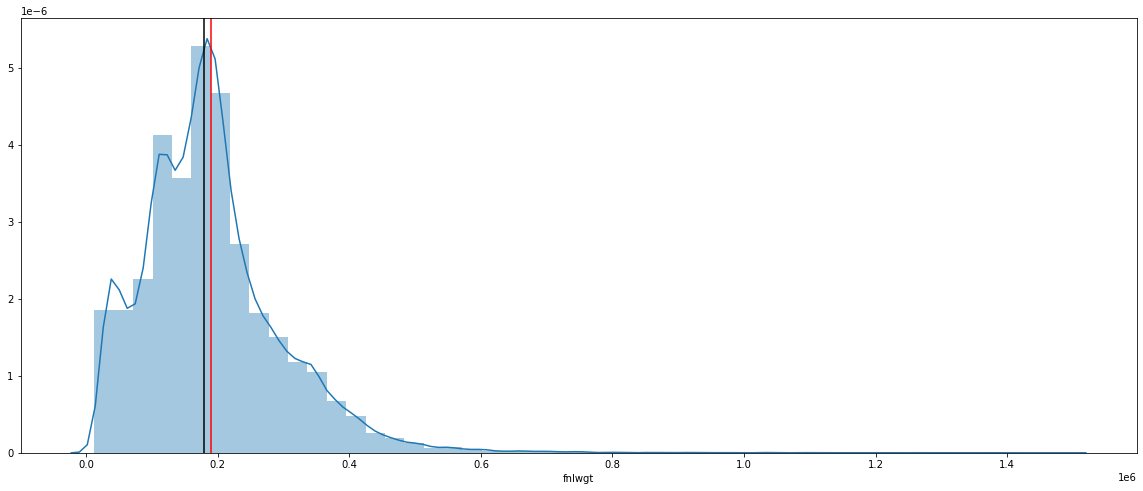

In [50]:
fig = plt.figure(figsize=(20,8))
sns.distplot(df['fnlwgt'])
    
mean_value = df['fnlwgt'].mean()
plt.axvline(mean_value, c='red')
    
median_value = df['fnlwgt'].median()
plt.axvline(median_value, c='black')

In [51]:
missing_values = df["fnlwgt"] == "? "
missing_values.value_counts()

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


False    32561
Name: fnlwgt, dtype: int64

In [52]:
missing_values = df["fnlwgt"] == 0
missing_values.value_counts()

False    32561
Name: fnlwgt, dtype: int64

There is no missing values

### EDUCATION

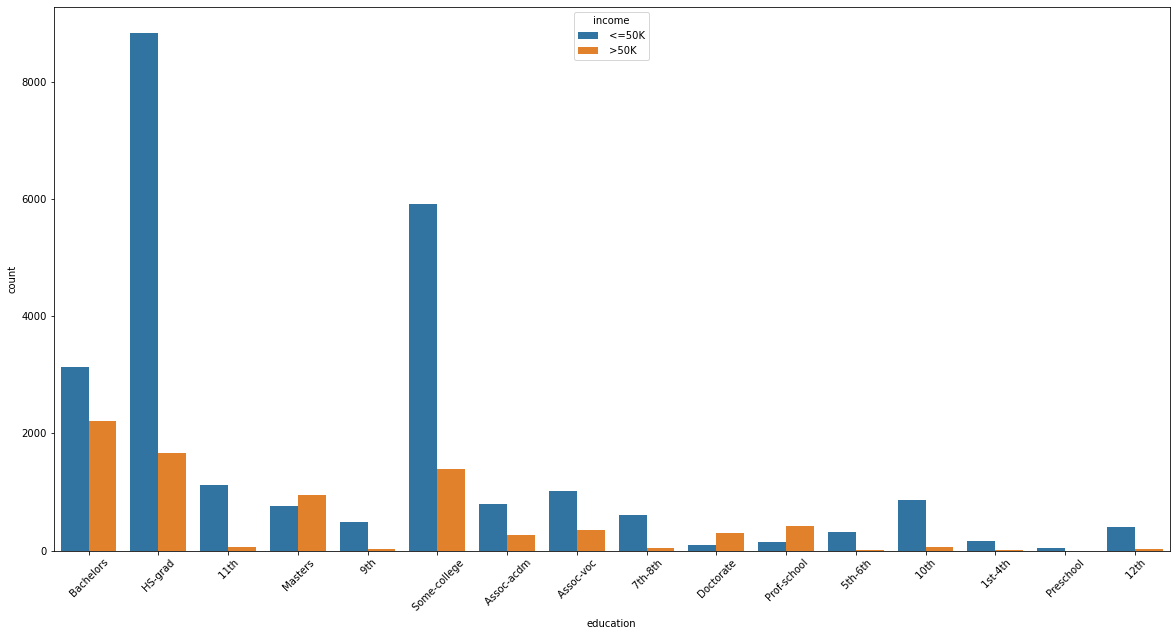

In [53]:
plt.subplots(figsize=(20, 10))
plt.xticks(rotation = 45)
sns.countplot(x = 'education', hue = 'income', data = df)
plt.show()

There is no missing values.

### EDUCATION-NUM

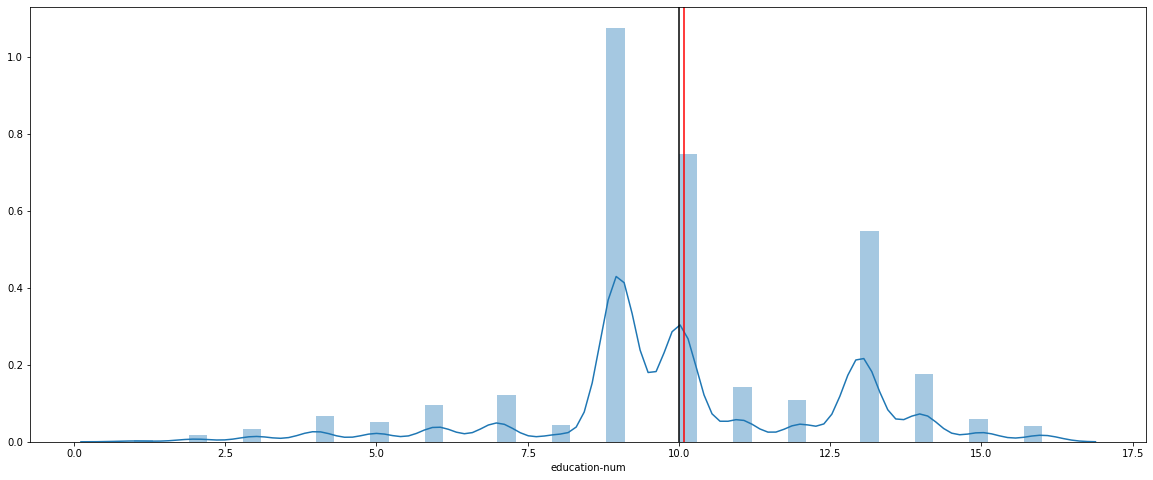

In [54]:
fig = plt.figure(figsize=(20,8))
sns.distplot(df['education-num'])
    
mean_value = df['education-num'].mean()
plt.axvline(mean_value, c='red')
    
median_value = df['education-num'].median()
plt.axvline(median_value, c='black')

There is no missng values. <br> Values aren't linear. Values are categorical.

### MARITAL-STATUS

### OCCUPATION

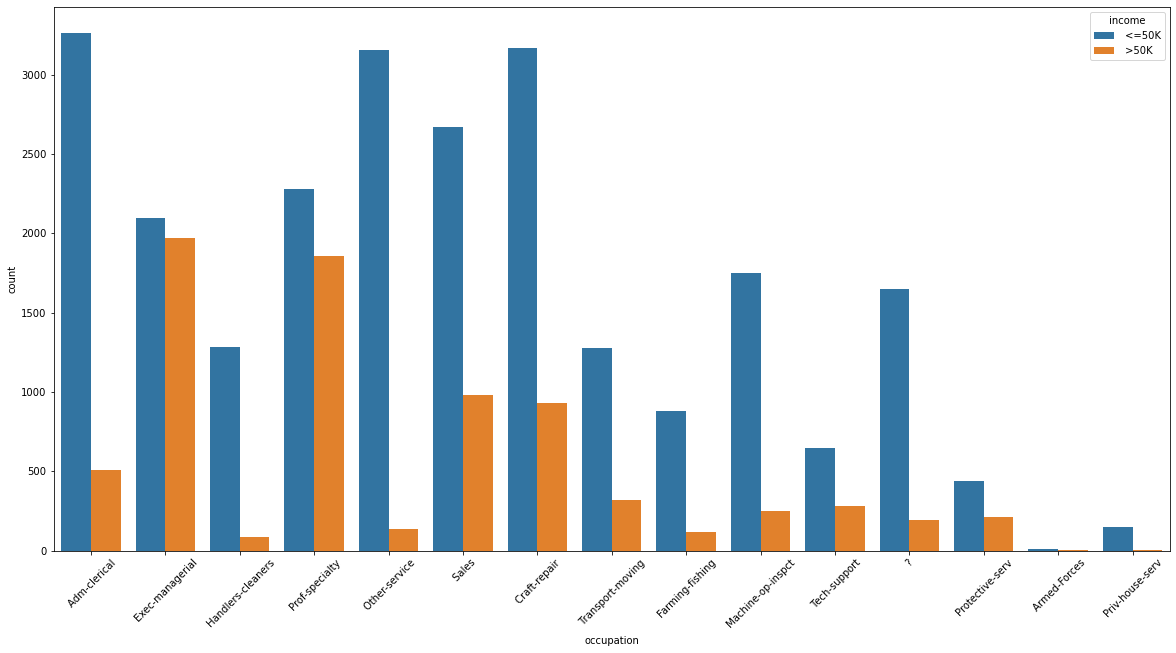

In [55]:
plt.subplots(figsize=(20, 10))
plt.xticks(rotation = 45)
sns.countplot(x = 'occupation', hue = 'income', data = df)
plt.show()

The data has missing values - cathegory "?".

### RELATIONSHIP

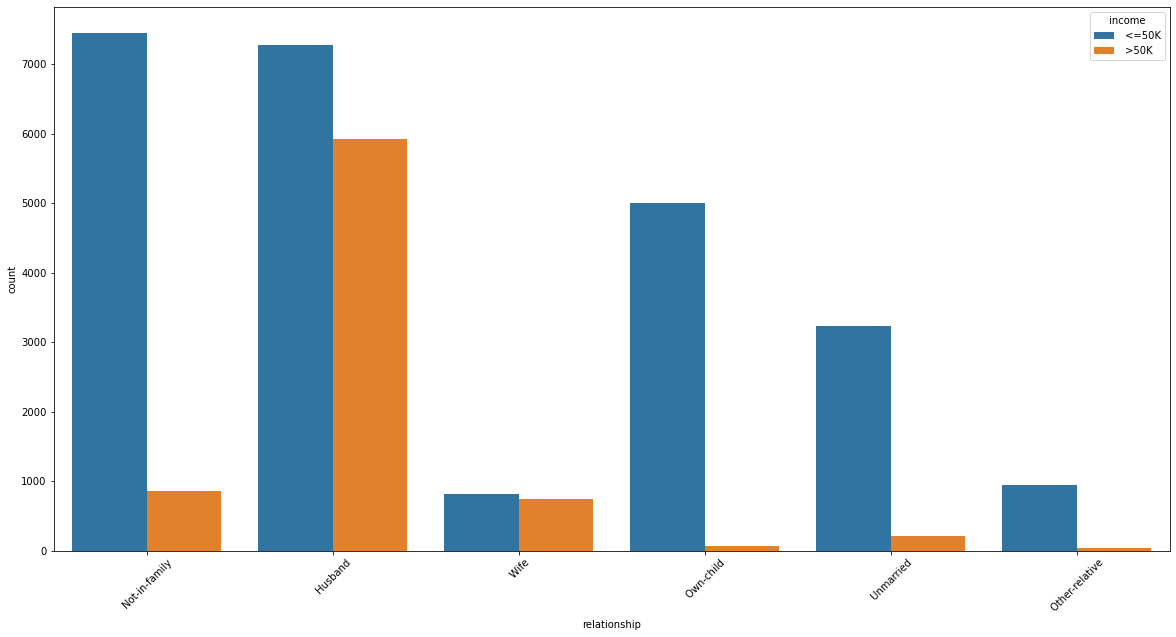

In [56]:
plt.subplots(figsize=(20, 10))
plt.xticks(rotation = 45)
sns.countplot(x = 'relationship', hue = 'income', data = df)
plt.show()

There is no missing values.

### RACE

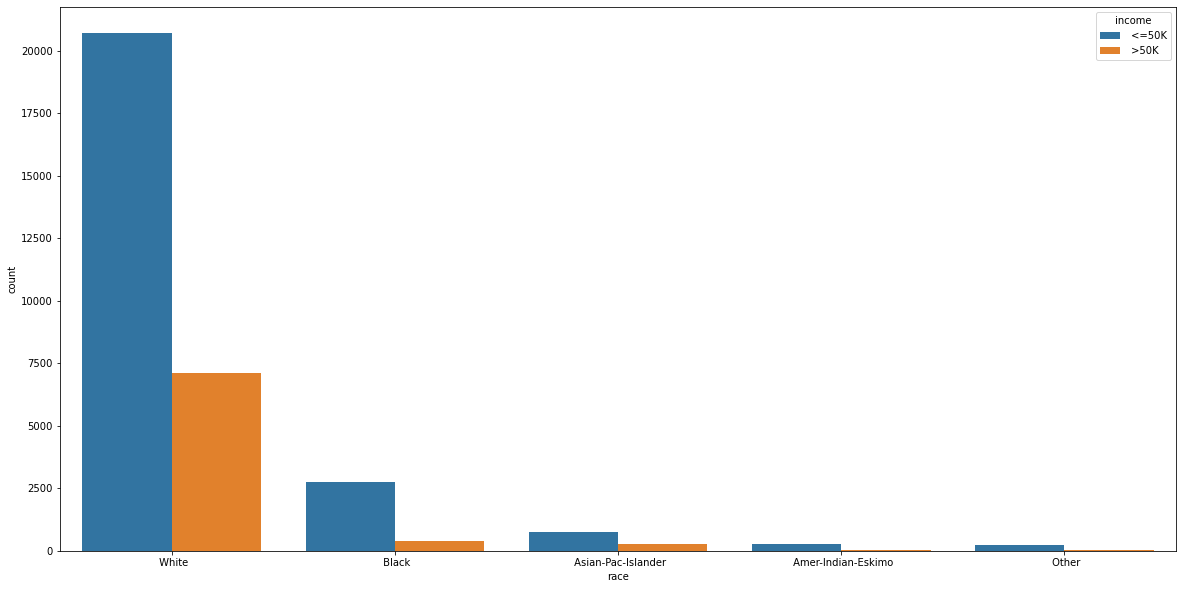

In [57]:
plt.subplots(figsize=(20, 10))
sns.countplot(x = 'race', hue = 'income', data = df)
plt.show()

The vast majority of people included in this dataset are of the WHITE race.

### SEX

sex      income
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
Name: income, dtype: int64
-----------------------------------


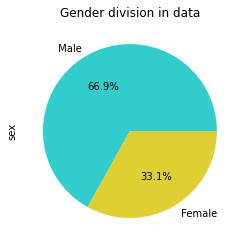

<Figure size 720x432 with 0 Axes>

-----------------------------------


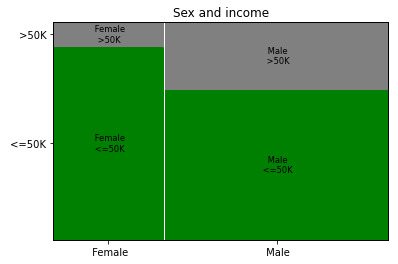

In [59]:
sex_income = pd.DataFrame({'sex': df['sex'], 'income': df['income']})
data = sex_income.income.groupby([sex_income.sex,  sex_income.income]).size()
plt.title('Gender division in data')
print(data)
print('-----------------------------------')
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#33cccc','#ded033'])
plt.figure(figsize=(10,6))
plt.show()
print('-----------------------------------')
props = lambda key: {'color': 'g' if ' <=50K' in key else 'gray'}
mosaic(data, title = "Sex and income", properties=props )
plt.show()

There are more Male participants than Female participants.<br>
More percentage of Male have an Income of more than 50K$ than Females.

### CAPITAL-GAIN and CAPITAL-LOSS

Capital gain - a profit that is made by selling property or an investment <br>
Capital loss - a loss as a result of the sale of an asset

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


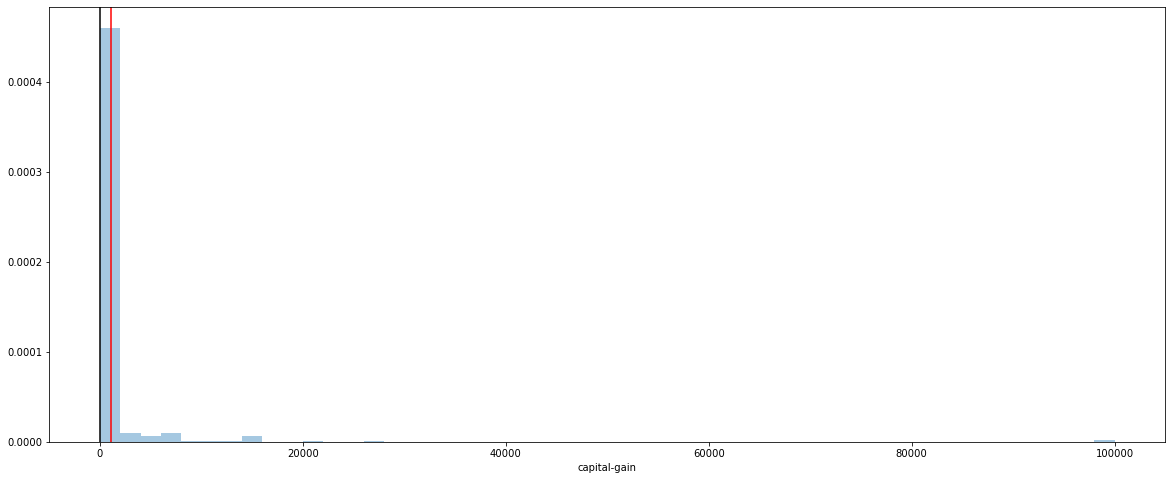

In [69]:
fig = plt.figure(figsize=(20,8))
sns.distplot(df['capital-gain'])
    
mean_value = df['capital-gain'].mean()
plt.axvline(mean_value, c='red')
    
median_value = df['capital-gain'].median()
plt.axvline(median_value, c='black')

In [70]:
print(df['capital-gain'].value_counts())

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital-gain, Length: 119, dtype: int64


/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


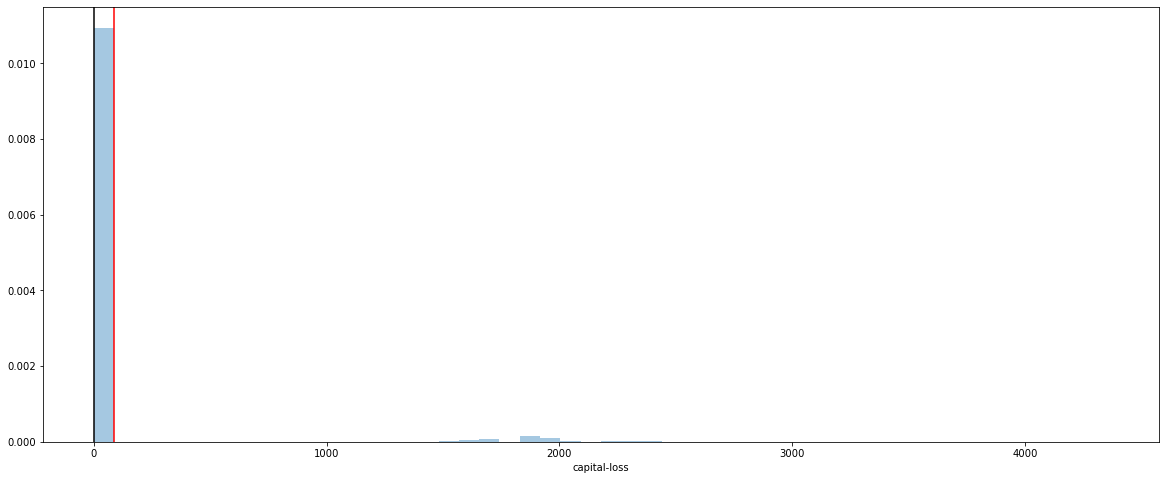

In [71]:
fig = plt.figure(figsize=(20,8))
sns.distplot(df['capital-loss'])
    
mean_value = df['capital-loss'].mean()
plt.axvline(mean_value, c='red')
    
median_value = df['capital-loss'].median()
plt.axvline(median_value, c='black')

In [72]:
print(df['capital-loss'].value_counts())

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital-loss, Length: 92, dtype: int64


### HOURS-PER-WEEK

In [ ]:
fig = plt.figure(figsize=(20,8))
sns.distplot(df['hours-per-week'])
    
mean_value = df['hours-per-week'].mean()
plt.axvline(mean_value, c='red')
    
median_value = df['hours-per-week'].median()
plt.axvline(median_value, c='black')

Most people work about 40h/week, but data is in range of 0 100

### NATIVE COUNTRIES

In [ ]:
print(df['native-country'].value_counts())

There is "?" category, which appears to be error. <br>
The majority of people are from United States.

### Adding target column with 0/1 values <br>
0 when INCOME <=50K <br>
1 when INCOME >50

In [ ]:
df['target'] = df['income']
df['target'] = np.where(df['income'].isin([' >50K']), 1, 0)

id there any missing values in income?

In [ ]:
missing_values_income = df['income'].isnull().sum()
print("Missing values in INCOME column ", missing_values_income)

In [62]:
missing_values = df["income"] == "? "
missing_values.value_counts()

False    32561
Name: income, dtype: int64

No missing values in INCOME column

Correlation matrix to identify their relation with income.

In [ ]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()

It’s clear that there is no high linear correlation between any of the continuous features and the target variable. <br> Also, Final Weight (fnlwgt) has zero correlation with target. <br>
So I'm dropping this column:

In [ ]:
df.drop(['fnlwgt'], axis=1)

## CLEANING THE DATA

In [ ]:
#def cleaning(df):
    